In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split


In [2]:
# Load the Excel file to examine the data structure and verify column names
file_path = 'encerrados2024.xlsx'
data = pd.read_excel(file_path)

# Displaying the first few rows and column names to understand data layout
data.head(), data.columns


(      Caso                   Processo Status do Caso  \
 0   341385  0208030-51.2011.8.26.0100      Encerrado   
 1   344065  0108548-02.2008.8.06.0001      Encerrado   
 2   463826  0929225-60.2012.8.26.0506      Encerrado   
 3   501004  0010874-73.2012.8.13.0329      Encerrado   
 4  1065138  0002221-80.2013.8.26.0072      Encerrado   
 
                                                Ação  Área (LBCA)  \
 0  Conhecimento - Condenatória - Obrigação de Fazer     Área 150   
 1          Conhecimento - Condenatória - Dano Moral  140 - Cível   
 2  Conhecimento - Condenatória - Obrigação de Fazer     Área 150   
 3          Conhecimento - Condenatória - Dano Moral  140 - Cível   
 4          Conhecimento - Condenatória - Dano Moral  140 - Cível   
 
   Data de Cadastro Data da Citação Data da Distribuição Data de Encerramento  \
 0       2011-11-10      2011-11-03           2011-11-03           2024-10-01   
 1       2012-01-02      2009-04-01           2009-04-01           2024-05-14 

In [3]:
data.shape

(220, 60)

In [4]:
# Dropping rows where the 'Sentença - Dispositivo da Sentença' column has the value '***'
data_cleaned = data[data['Sentença - Dispositivo da Sentença'] != '***']

# Display the shape of the cleaned data to confirm rows have been removed
data_cleaned.shape

(214, 60)

In [5]:
# Evaluating the balance of the target variable 'Sentença - Dispositivo da Sentença'
target_counts = data_cleaned['Sentença - Dispositivo da Sentença'].value_counts(normalize=True) * 100
target_counts


Improcedente               27.102804
Extinção sem mérito        26.635514
Parcialmente Procedente    24.299065
Procedente                 21.962617
Name: Sentença - Dispositivo da Sentença, dtype: float64

In [6]:
# Explicitly creating a new variable with the specified mapping for 'Sentença - Dispositivo da Sentença'
mapping = {
    'Extinção sem mérito': 0,
    'Improcedente': 1,
    'Parcialmente Procedente': 2,
    'Procedente': 3
}

# Apply this mapping to create a new column with the specified numeric values
data_cleaned['target_custom_numeric'] = data_cleaned['Sentença - Dispositivo da Sentença'].map(mapping)

# Display the first few rows to confirm the new variable
data_cleaned[['Sentença - Dispositivo da Sentença', 'target_custom_numeric']].head()


C:\Users\crist\AppData\Local\Temp\ipykernel_28108\570199276.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['target_custom_numeric'] = data_cleaned['Sentença - Dispositivo da Sentença'].map(mapping)


,Sentença - Dispositivo da Sentença,target_custom_numeric
0,Improcedente,1
1,Improcedente,1
2,Procedente,3
3,Procedente,3
4,Parcialmente Procedente,2


In [7]:
data_cleaned.head(5)

,Caso,Processo,Status do Caso,Ação,Área (LBCA),Data de Cadastro,Data da Citação,Data da Distribuição,Data de Encerramento,UF,...,Apelação/RI - Houve Recurso?,Apelação/RI - Quem Apresentou o Recurso,Apelação/RI - Câmara Julgadora,Apelação/RI - Relator,Apelação/RI - Revisor,Apelação/RI - Vogal,Apelação/RI - Data do Acórdão,Apelação/RI - Dispositivo do Acórdão Quanto ao Recurso do Google,Apelação/RI - Dispositivo do Acórdão Quanto ao Recurso da Parte Contrária,target_custom_numeric
0,341385,0208030-51.2011.8.26.0100,Encerrado,Conhecimento - Condenatória - Obrigação de Fazer,Área 150,2011-11-10,2011-11-03,2011-11-03,2024-10-01,SP,...,Sim,Parte Contrária,4ª Câmara de Direito Privado,Carlos Henrique Miguel Trevisan,Maia da Cunha,Natan Zelinschi de Arruda,2014-08-07,Não houve recurso do Google,Provimento Parcial,1
1,344065,0108548-02.2008.8.06.0001,Encerrado,Conhecimento - Condenatória - Dano Moral,140 - Cível,2012-01-02,2009-04-01,2009-04-01,2024-05-14,CE,...,Sim,Parte Contrária,1ª Câmara de Direito Privado,JOSÃ‰ RICARDO VIDA PATROCÃ_x008d_NIO,FRANCISCO MAUTO FERREIRA LIBERATO,CARLOS AUGUSTO GOMES CORREIA,2024-04-10,NaN,Negado Provimento,1
2,463826,0929225-60.2012.8.26.0506,Encerrado,Conhecimento - Condenatória - Obrigação de Fazer,Área 150,2012-07-17,2012-07-17,2012-06-13,2024-08-05,SP,...,Sim,Google,28ª Câmara Extraordinária de Direito Privado,J.B. Paula Lima,Enio Santarelli Zuliani,Maia da Cunha,2017-06-07,Negado Provimento,NaN,3
3,501004,0010874-73.2012.8.13.0329,Encerrado,Conhecimento - Condenatória - Dano Moral,140 - Cível,2012-12-12,2012-12-11,2012-11-30,2024-05-17,MG,...,Sim,Google,13ª CÂMARA cível,Alberto Henrique Costa de Oliveira,ALBERTO HENRIQUE,Luiz Carlos Gomes da Mata,2015-06-25,Provimento Parcial,NaN,3
4,1065138,0002221-80.2013.8.26.0072,Encerrado,Conhecimento - Condenatória - Dano Moral,140 - Cível,2013-05-22,2013-05-21,2013-03-12,2024-09-16,SP,...,Não,***,NaN,NaN,NaN,NaN,NaT,NaN,NaN,2


In [8]:
import matplotlib.pyplot as plt

# Plotting the percentage of "Sentença - Dispositivo da Sentença" by state
plt.figure(figsize=(12, 8))
state_sentence_percentages.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title("Porcentagem de Sentenças por Estado")
plt.xlabel("Estado (UF)")
plt.ylabel("Porcentagem (%)")
plt.legend(title="Sentença - Dispositivo da Sentença")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


NameError: name 'state_sentence_percentages' is not defined

<Figure size 1200x800 with 0 Axes>

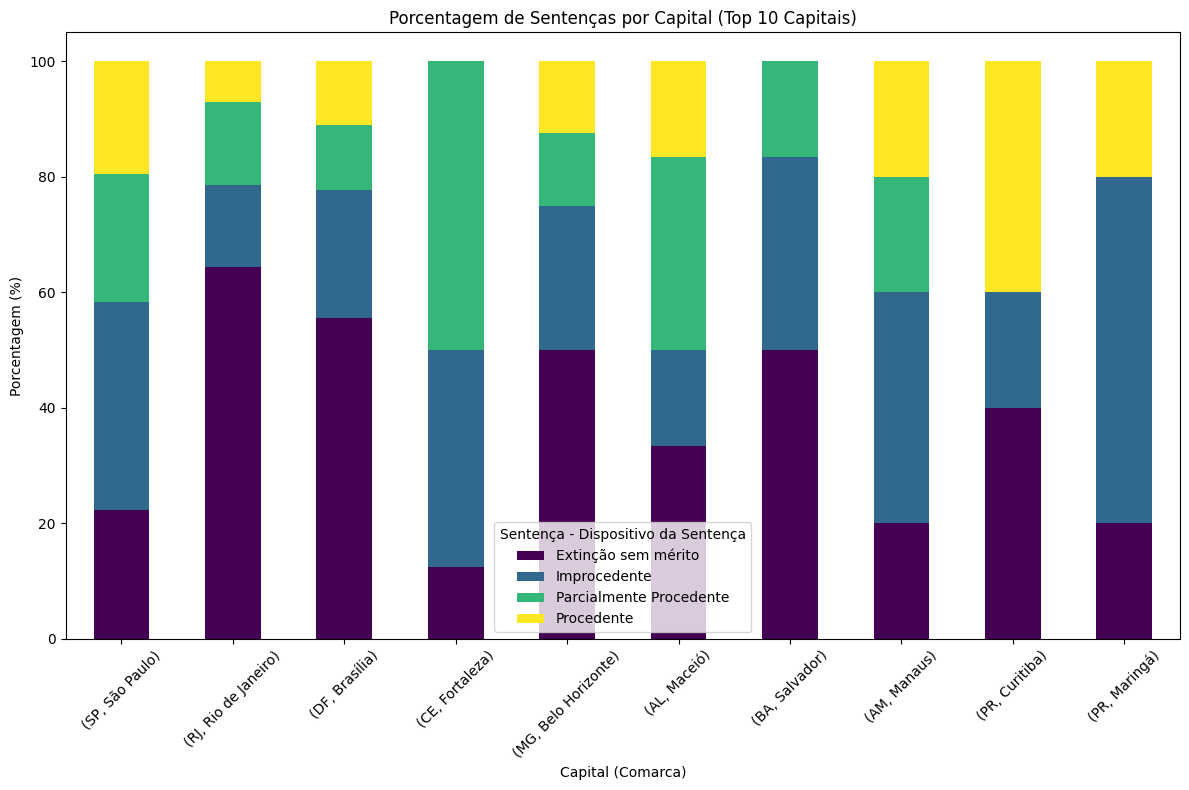

In [ ]:
# Plotting the percentage of "Sentença - Dispositivo da Sentença" by capital (limited for clarity)
# Displaying only the top 10 capitals by count to ensure readability in plot
top_capitals = capital_sentence_counts.sum(axis=1).nlargest(10).index
capital_sentence_percentages_top = capital_sentence_percentages.loc[top_capitals]

plt.figure(figsize=(12, 8))
capital_sentence_percentages_top.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title("Porcentagem de Sentenças por Capital (Top 10 Capitais)")
plt.xlabel("Capital (Comarca)")
plt.ylabel("Porcentagem (%)")
plt.legend(title="Sentença - Dispositivo da Sentença")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Identifying date columns in the dataset by checking the data types
date_columns = data_cleaned.select_dtypes(include=['datetime64']).columns.tolist()

# Dropping identified date columns from the features
data_cleaned = data_cleaned.drop(columns=['target_custom_numeric'] + ['Sentença - Dispositivo da Sentença']+ ['Caso']+ ['Processo'] +['Status do Caso'] + date_columns)
data_cleaned.shape

KeyError: "['target_custom_numeric', 'Sentença - Dispositivo da Sentença', 'Caso', 'Processo', 'Status do Caso'] not found in axis"

In [9]:
# Defining features and target based on the transformations and removing date columns
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data_cleaned['target_custom_numeric'])
X = pd.get_dummies(X, drop_first=True)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the XGBoost Classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train, y_train)

# Predict on the test data
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

accuracy, report

C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


TypeError: object of type 'numpy.int64' has no len()

In [19]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the XGBoost Classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_train, y_train)

# Predict on the test data
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

accuracy, report

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Ação: object, Área (LBCA): object, UF: object, Comarca: object, Fórum: object, Vara: object, Orgão: object, Causa Raiz 1: object, Causa Raiz 2: object, Causa Raiz 3: object, Causa Raiz 4: object, Causa Real 1: object, Causa Real 2: object, Causa Real 3: object, Causa Real 4: object, Causa Real 5: object, Causa Real 6: object, Causa de Fechamento 1: object, Causa de Fechamento 2: object, Causa Real Jurídica 1: object, Causa Real Jurídica 2: object, Causa Real Jurídica 3: object, Causa Real Jurídica 4: object, Causa Real Jurídica 5: object, Pedido 1 - Descrição: object, Pedido 2 - Descrição: object, Pedido 3 - Descrição: object, Pedido 4 - Descrição: object, Pedido 5 - Descrição: object, Pedido 6 - Descrição: object, Pedido 7 - Descrição: object, Pedido 8 - Descrição: object, Departamento 1: object, Departamento 2: object, Departamento 3: object, Departamento 4: object, Departamento 5: object, Label 1: object, Label 2: object, Label 3: object, Label 4: object, Motivo das Ações: object, Sentença - Data da Sentença: object, Apelação/RI - Houve Recurso?: object, Apelação/RI - Quem Apresentou o Recurso: object, Apelação/RI - Câmara Julgadora: object, Apelação/RI - Relator: object, Apelação/RI - Revisor: object, Apelação/RI - Vogal: object, Apelação/RI - Dispositivo do Acórdão Quanto ao Recurso do Google: object, Apelação/RI - Dispositivo do Acórdão Quanto ao Recurso da Parte Contrária: object

In [13]:
# Redefining the feature set without attempting to drop columns that are not present in data_encoded
# Ensuring the correct columns are used for feature importance and PCA analysis

# Defining features and target
# Dropping identified date columns from the features
#X = data_cleaned.drop(columns=['target_custom_numeric'] + ['Sentença - Dispositivo da Sentença']+ ['Caso']+ ['Processo'] +['Status do Caso'] date_columns)
y = data_cleaned['target_custom_numeric']

# Using RandomForestRegressor to evaluate feature importance
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X, y)

# Extract feature importances and sort them
feature_importances = pd.Series(regressor.feature_importances_, index=X.columns).sort_values(ascending=False)
top_10_features_importance = feature_importances.head(10)

# PCA analysis to determine principal components
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

# Get the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Displaying top features based on feature importance and PCA explained variance ratio
top_10_features_importance, explained_variance_ratio

ValueError: could not convert string to float: 'Conhecimento - Condenatória - Obrigação de Fazer'

In [ ]:
# Train a RandomForestRegressor to evaluate feature importance without date columns
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X, y)

# Extract and sort feature importances
feature_importances = pd.Series(regressor.feature_importances_, index=X.columns).sort_values(ascending=False)
top_10_features_importance = feature_importances.head(10)

# Display the top 10 most important features influencing the target
top_10_features_importance


In [ ]:
data_cleaned.shape

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, chi2

# Filter dataset for Department 'YouTube' in any of the columns AN to AR
data_youtube = data_cleaned[
    (data['Departamento 1'] == 'YouTube') |
    (data['Departamento 2'] == 'YouTube') |
    (data['Departamento 3'] == 'YouTube') |
    (data['Departamento 4'] == 'YouTube') |
    (data['Departamento 5'] == 'YouTube')
]

# Select columns for Causa Raiz 3 and target Sentença - Dispositivo da Sentença
data_filtered = data_youtube[['Causa Raiz 3', 'Sentença - Dispositivo da Sentença'] + list(data.columns[0:60])]

# Filter for only cases with a specific Causa Raiz 3 value if applicable
data_filtered = data_filtered.dropna(subset=['Causa Raiz 3', 'Sentença - Dispositivo da Sentença'])

# Encoding target and categorical variables for model processing
data_filtered['target'] = data_filtered['Sentença - Dispositivo da Sentença'].astype('category').cat.codes
data_filtered.drop(columns=['Sentença - Dispositivo da Sentença'], inplace=True)

# Encoding categorical features, filling missing values for simplicity
data_encoded = pd.get_dummies(data_filtered.fillna('Unknown'), drop_first=True)

# Split data into features (X) and target (y)
X = data_encoded.drop(columns=['target'])
y = data_encoded['target']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Select top features using SelectKBest with chi-squared test
selector = SelectKBest(chi2, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Identify selected feature names
selected_features = X.columns[selector.get_support(indices=True)].tolist()

# Train a RandomForestClassifier as a baseline model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_selected, y_train)

# Model evaluation
y_pred = clf.predict(X_test_selected)
report = classification_report(y_test, y_pred, output_dict=True)

# Output selected features and classification report
selected_features, report


C:\Users\crist\AppData\Local\Temp\ipykernel_23244\534380961.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_youtube = data_cleaned[


AttributeError: 'DataFrame' object has no attribute 'cat'